# Предположения Метода Наименьших Квадратов
**Источник (теория) – специализация Yandex & MIPT "Машинное обучение и анализ данных"**

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from scipy import stats
import statsmodels.formula.api as smf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('../../data/weights_heights.csv', index_col='Index')

In [3]:
data.head()

,Height,Weight
Index,,
1,65.78331,112.9925
2,71.51521,136.4873
3,69.39874,153.0269
4,68.21660,142.3354
5,67.78781,144.2971


In [4]:
y, x = data['Height'], data['Weight']

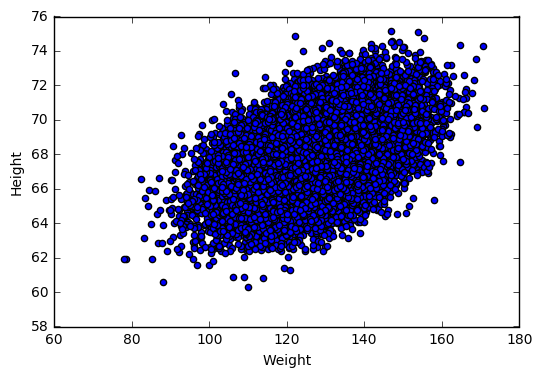

In [5]:
scatter(x, y)
xlabel('Weight')
ylabel('Height');

## Предположения Метода Наименьших Квадратов

### 1. Истинная модель $y$ действительно линейна:
$$y = X\beta + \epsilon$$ $$\epsilon \sim N(\mu, \sigma^2)$$

**Как проверить.**
Построить графики остатков $\epsilon_i = y_i - \hat{y}_i, i=1,...,n$ в зависимости от признаков $x_j$,
где $y$ — это истинные значения, а $\hat{y}$ — предсказываемые.

Зависимости остатков от $x_j$ не должно просматриваться.


In [6]:
model = smf.ols('Height ~ Weight', data=data)
fitted = model.fit()

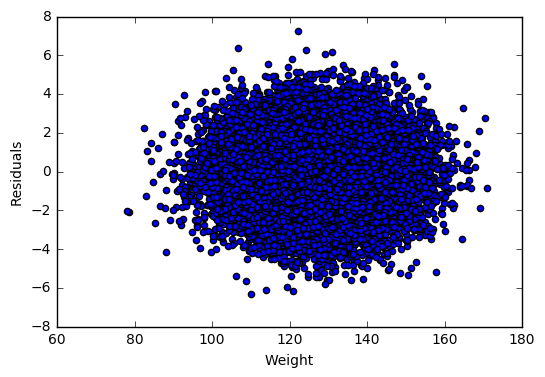

In [7]:
scatter(x, fitted.resid);
xlabel('Weight')
ylabel('Residuals');

### 2. Случайность выборки
Следующее предположение — это предположение о случайности выборки. Требуется, чтобы выборка была независимой и одинаково распределенной. Это предположение может нарушаться несколькими способами. Первый способ более тяжелый: если объекты, на которых измерены признаки и отклик, зависимы, то всё плохо: дисперсии ошибки и коэффициентов недооцениваются, и все статистические критерии, которые на этом основаны, перестают работать корректно.
Еще это предположение может нарушаться, если выборка отобрана из генеральной совокупности не случайно, а каким-то образом отфильтрована. Фильтровать генеральную совокупность по какому-то признаку $z$ можно только в случае, если
$$E(y|x,z) = E(y|x)$$
то есть $z$ не добавляет никакой новой информации об $y$.
Если выборка отфильтровывалась как-то иначе, например, просто по одному из признаков, содержащихся
в $x$, то выводы, построенные по такой модели, можно распространять только на отфильтрованную генеральную совокупность. Например, если в выборке испытуемые только младше 50 лет, то нельзя ничего сказать об испытуемых в генеральной совокупности, которым больше 50 лет.

### 3. Полнота ранга X
Следующее предположение: матрица X должна иметь полный столбцовый ранг, то есть
$$rank X = k + 1.$$
Если в выборке есть линейно зависимые признаки, то дисперсия оценки коэффициентов при таких признаках будет бесконечной. Это не очень удобно при построении доверительных интервалов: они будут иметь бесконечную ширину. И кроме того, гипотезы тоже так не проверить.
Если возникла такая проблема, это значит, что от каких-то признаков в модели придется избавиться. По- мимо всего прочего, для категориальных переменных нельзя использовать OHE (one-hot encoding), которое использовалось в предыдущих курсах. Дело в том, что при кодировании каждого уровня фактора своей бинарной переменной мы получаем, что в сумме такие переменные дают единичный столбец, а он в матрице $X$ уже есть, поэтому столбцы получаются линейно зависимы. Вместо этого нужно использовать другой способ кодирования: dummy-кодирование. Если признак $x_j$ принимает $m$ различных значений, то его нужно кодировать $m−1$ фиктивной переменной.


### 4. Случайность ошибок
$$H_0 : E(\epsilon |x ) = 0$$
$$H_1 : E(\epsilon |x ) \neq 0$$
Это легко проверить по данным. Для этого нужно построить регрессию $y$ по $x$, вычислить остатки и проверить гипотезу о том, что среднее значение остатков равно 0. Это можно сделать, например, с помощью критерия Стьюдента.

In [8]:
stats.ttest_1samp(fitted.resid, 0)

Ttest_1sampResult(statistic=-5.449992123943544e-12, pvalue=0.99999999999565159)

Нулевая гипотеза о равенстве нуля среднего значения ошибок уверено не отвергается.

### 5. Гомоскедастичность ошибок
Пятое предположение — предположение гомоскедастичности ошибки:
$$D(\epsilon|x) = \sigma^2.$$
Это предположение можно проверять двумя способами. Первый, нестрогий, — это визуальный анализ. Нужно построить графики зависимости остатков от всех признаков $x_j$ и посмотреть, выглядят ли точки на этом графике как горизонтальная полоса. Если вместо горизонтальной полосы на графике изображено что-то расширяющееся или сужающееся, значит, предположение гомоскедастичности не выполняется. Формально это предположение можно проверять с помощью критерия Бройша-Пагана.

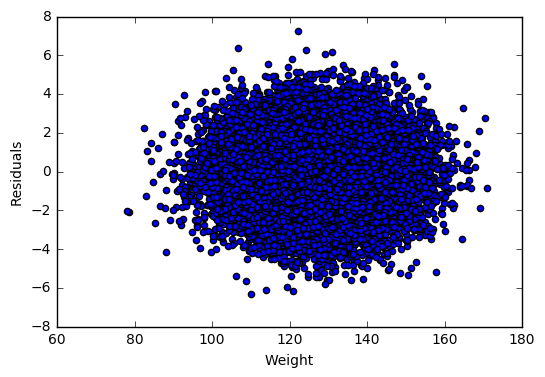

In [9]:
scatter(x, fitted.resid);
xlabel('Weight')
ylabel('Residuals');

In [10]:
import statsmodels.stats.api as sms

In [11]:
print('Breusch-Pagan test: p=%f' % sms.het_breushpagan(fitted.resid, fitted.model.exog)[1])

Breusch-Pagan test: p=0.499545


Нулевая гипотеза критерия Бройша-Пагана о том, что ошибки гомоскедастичны (их дисперсия постоянна), не отвергается.

### 6. Нормальность ошибок
Наконец, шестое предположение — это предположение нормальности. Есть визуальный способ: нужно построить ку-ку график и посмотреть, лежат ли точки на этом графике более-менее на одной прямой. Также есть формальный способ: можно использовать статистические критерии для проверки нормальности. Среди всего разнообразия критериев рекомендуется использовать критерий Шапиро-Уилка.

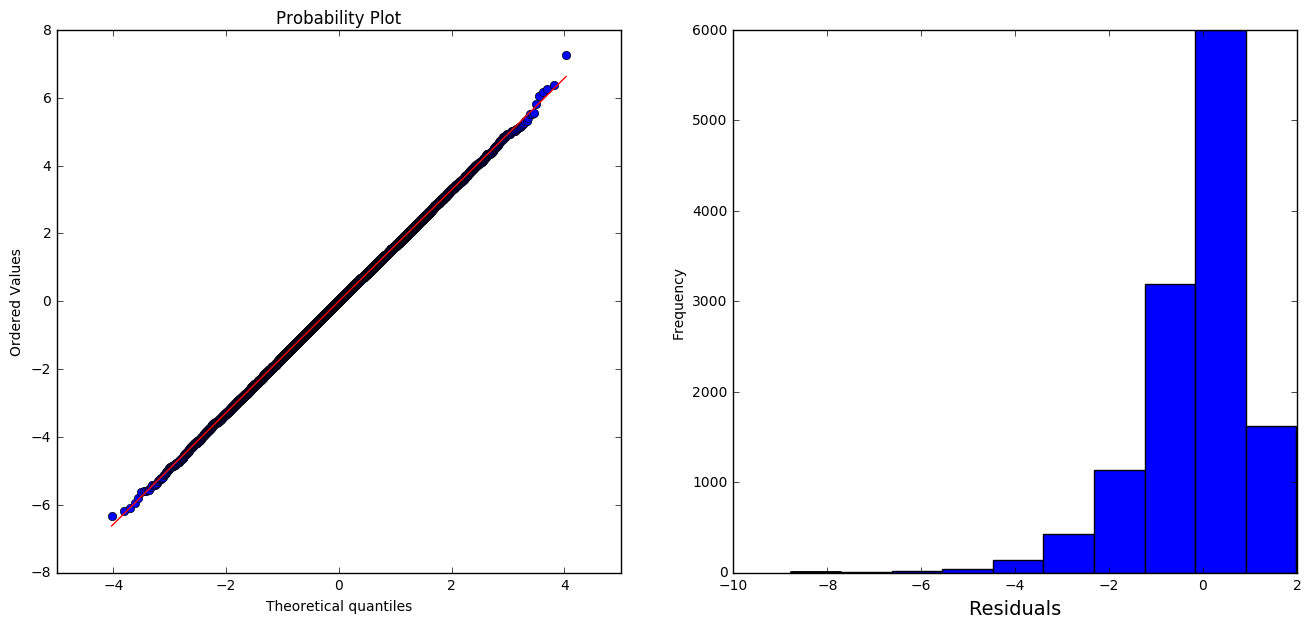

In [12]:
plt.figure(figsize(16,7))
plt.subplot(121)
stats.probplot(fitted.resid, dist="norm", plot=pylab);
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14);

In [13]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(fitted.resid))

Shapiro-Wilk normality test, W-statistic: 0.999929, p-value: 0.771898


Нулевая гипотеза о нормальности распределения остатков модели не отвергается (причем уверенно).